# Importing Relevant Libraries

In [ ]:
import torch
import pandas as pd
import cv2
import numpy as np 
from torchvision.utils import make_grid
import torchvision 
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Retriving Kaggle dataset

In [ ]:
!pip install q kaggle
# from google.colab import files
# files.upload()


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download alxmamaev/flowers-recognition --force

 99% 223M/225M [00:01<00:00, 162MB/s]
100% 225M/225M [00:01<00:00, 155MB/s]


In [ ]:
! unzip '/content/flowers-recognition.zip'

## get mean and std

In [ ]:
ex_img= Image.open('/content/flowers/daisy/10140303196_b88d3d6cec.jpg')
tense = torchvision.transforms.Compose([
      torchvision.transforms.Resize((224, 224)),  # smaller sized imagaes give faster results
      torchvision.transforms.ToTensor()])

ex_imgT= tense(ex_img)

mean, std = ex_imgT.mean([1,2]), ex_imgT.std([1,2])
print('img mean is: ', mean)
print('Standard Dev is: ', std)

img mean is:  tensor([0.6520, 0.6200, 0.5089])
Standard Dev is:  tensor([0.2128, 0.2142, 0.3178])


In [ ]:
def prepare_imgs(imgs):

  prep = torchvision.transforms.Compose([
      torchvision.transforms.Resize((224, 224)),  # smaller sized imagaes give faster results
      torchvision.transforms.ToTensor(),  # Trnsfor to tensor
      torchvision.transforms.Normalize(mean =[0.6520, 0.6200, 0.5089] , std =[0.2128, 0.2142, 0.3178] ) # Normalise to get data in range
  ])
  
  transformed_img = prep(imgs)

  return transformed_img

In [ ]:
dataset = torchvision.datasets.ImageFolder('/content/flowers', transform = prepare_imgs)

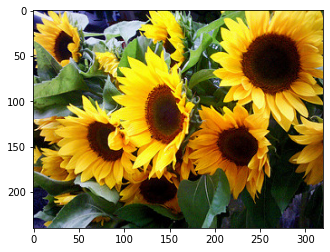

In [ ]:
plt.imshow(Image.open(dataset.imgs[3000][0]))

# Splitting dataset into training and validation sets

In [ ]:
train_set, rem_set = train_test_split(dataset, test_size= 0.2)
print('the training set size is: ', len(train_set))
print('Remaining  set size is :', len(rem_set))

the training set size is:  3453
Remaining  set size is : 864


In [ ]:
validation_set, test_set = train_test_split(rem_set, test_size= 0.05)
print('the validation set size is: ', len(validation_set))
print('Test set size is :', len(test_set))

the validation set size is:  820
Test set size is : 44


In [ ]:
batch_size = 32 #This is the number of samples used to estimate error gradient before updating the weights 
num_work= 2 # how many subprocess wil be carried out for dataloding

train_loader = DataLoader(train_set, batch_size, shuffle= True, num_workers=num_work)
val_loader = DataLoader(validation_set, batch_size, shuffle= True, num_workers=num_work)
test_loader =DataLoader(test_set, batch_size, shuffle= True, num_workers=num_work)

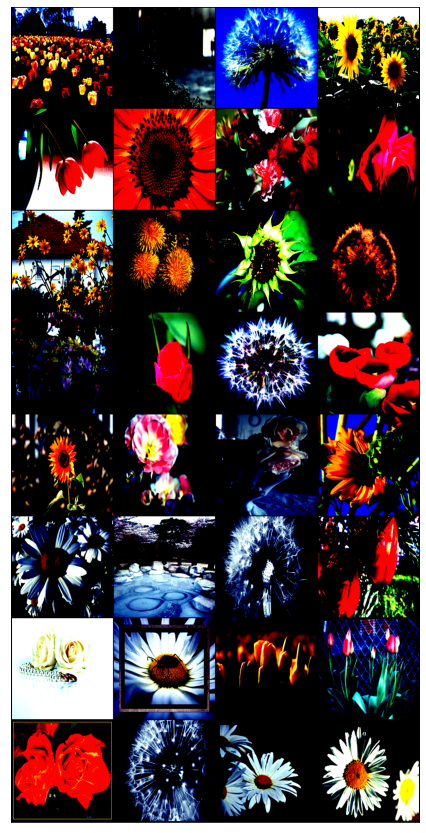

In [ ]:
for images, labels in train_loader:

  fig, ax =plt.subplots(figsize = (15,15))
  ax.set_xticks([])
  ax.set_yticks([])

  ax.imshow(make_grid(images, 4).clip(0,1).permute(1,2,0))

  break

# Calculating accuracy

#### Accuracy is the percentage of correct predictions for the test dat. it is calculated by dividing the correct prediction by the total number of predictions. We calculate accuracy with the test/validation set by evaluating the predicted vrs the actual labels

In [ ]:
def accuracy(output, labels):
  _, preds = torch.max(output, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds) ) *100

# Building a CNN





#### A CNN(Convolutional neural network) is a deep learning framework mosly applied to images. It takes an input image and applies techniques to the image to differentiate it from others. 

#### It is able to recognize features in the input images that serve as the basis for classification, it also reduces the dimension of the images for faster processing without losing any details. 





### **1.) The Convolution layer**

#### The convolutional layer of the CNN serves to apply a filter(Kernel) to the image and thus extract feautures. Think of it as a sharperning filter that shows image details more clearly. 
#### This kernel slides over the image for all three channels(RGB) until the image is completely convolved. Filters are usually 3x3 kernels but sizes can vary, however they have to be a square matrix. 
#### The convolution operation is done by dot multiplying the image and the padded kernel in the fourier domain. 

#### In PyTorch the convolutional layer is called by `torch.nn.Conv2d()`

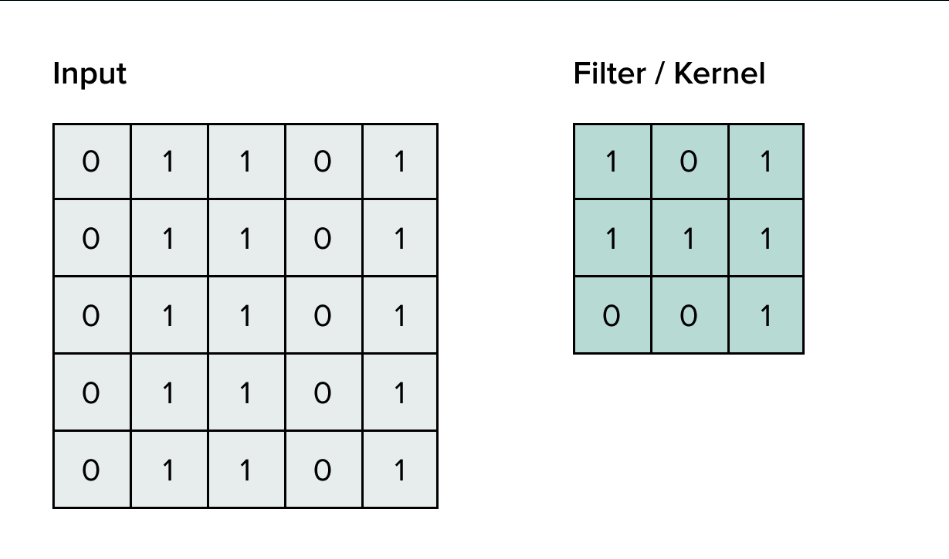

#### The output of a convolutional layer can be calculated by `width_out  = (width_in - Kernel_size +2*pooling)/stride +1` , `Height_out = (Height_in - Kernel_size +2*pooling)/stride +1` 

### **2.) Pooling Layer**

#### This layer is responsible for dimension reduction, thus reducing the computational power used to process the images. It is also good for retrieving rotational and translation invarient features from the image. 

#### Two types of pooling **max** and **average**. Max pooling takes the maximum pixel from the portion of image visited by the kernel.It also does noise reduction.While average pooling takes the average of the pixels in the portion visited by the kernel. 
#### In pytorch max pooling is `torch.nn.MaxPool2d()` and average pooling is `torch.nn.AvgPool2d()`.


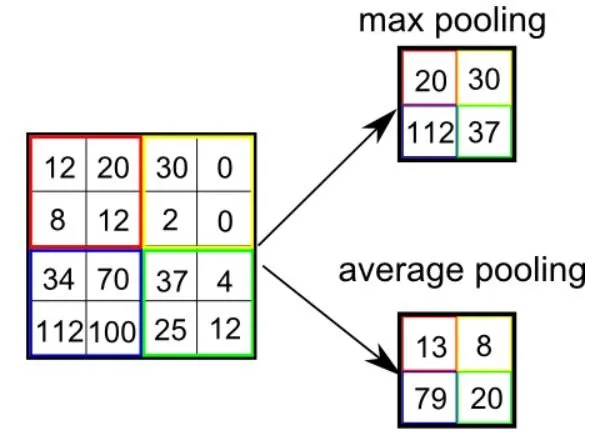

#### The output from the pooling layer is calculated as 
`width_out= (width-kernel_size/stride)+1,  Height_out= (Height-kernel_size/stride)+1 `


 



### **3.) The fully connected layer (Linear layers)**

#### These layers are responsible for connecting the neurons in a neural network. They are what ensures the computer learns the feautures that have been extracted from the convolution and pooling layers. It is also where the weights are applied in a neural network. 

#### Some linear layers include: 

1.   ReLu(rectified Linear Layer)
2.   Softmax
3.   Linear layer
4.   Sigmoid layer


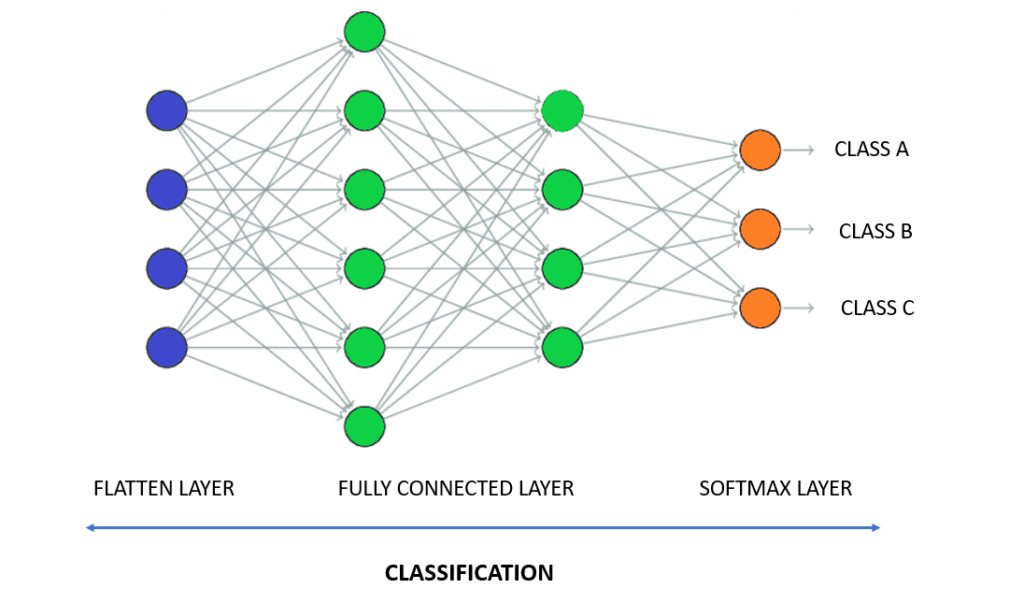





In [ ]:

model = nn.Sequential(
    #layer1
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output size= 16 x224 x224
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels =64,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),# Output size= 64 x 112 x 112

    #Layer 2
    nn.Conv2d(in_channels= 64, out_channels=128,kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(2,2), # Output size= 128 x 56 x 56

    #Layer 3
    nn.Conv2d(in_channels= 128, out_channels=256,kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(2,2), # Output size= 256 x 28 x 28

    # Fully connected layer 
    nn.Flatten(),
    nn.Linear(256*28*28, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 5),
    


)
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Note:
# stride in a cnn is resposible for the amount of movement a kernel moves over an image


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

## Testing the model

In [ ]:
model_image= Image.open(dataset.imgs[400][0])
model_img_tense= prepare_imgs(model_image)


model_test=model(model_img_tense.unsqueeze(0).to(device))

ex_model_= model_test



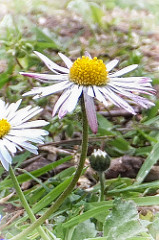

In [ ]:
model_image

## Setting values for traing the Neural Network

In [ ]:
#learning_rate =0.0001
optimizer =torch.optim.Adam(params=model.parameters(), lr= 0.001)


# Learning Rate Scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5,gamma = 0.5)

## Chosing a loss function

In [ ]:
def calc_loss(prediction ,actual):
  loss = nn.CrossEntropyLoss()

  return loss(prediction, actual)


In [ ]:
def train_model(model, optim, train_data, epochs=30):
  '''
  model: the model to be trained
  optim: The optimizer chosen in this case Adam
  train_data: training data
  '''

  #training sequence
  epoch_loss = []
  epoch_accuracy =[]

  for epoch in range(epochs):

    for img, label  in train_data:
      #transforming images to tensor and resizing 
      # img =prepare_imgs(img) images already transformed to tensor
      img =img.to(device)

      label  = label.to(device)

      #resetting gradients
      optim.zero_grad()

      #running img through model
      preds = model(img)
     

      #calculate loss
      #cross entropy loss a reducing loss is good as the closer to zero the more accurate
      _loss = calc_loss(preds, label)
      loss =_loss.item()

      #Calclulate accuracy
    
      acc = accuracy(preds, label)
      

      #loss step backwards 
      _loss.backward()
      optim.step()

    # results 
    epoch_loss.append(_loss.detach().cpu().numpy())
    epoch_accuracy.append(acc.detach().cpu().numpy())
    print( 'Epoch: {}'.format(epoch+1), 'loss: {:.4f}'.format(loss), 'accuracy: {:.2f}'.format(acc) )

  return epoch_loss, epoch_accuracy





In [ ]:
loss, acc= train_model(model, optimizer, train_loader)

Epoch: 1 loss: 1.4374 accuracy: 41.38
Epoch: 2 loss: 1.2143 accuracy: 44.83
Epoch: 3 loss: 1.2397 accuracy: 51.72
Epoch: 4 loss: 1.0071 accuracy: 65.52
Epoch: 5 loss: 0.8675 accuracy: 65.52
Epoch: 6 loss: 0.7269 accuracy: 75.86
Epoch: 7 loss: 0.1798 accuracy: 96.55
Epoch: 8 loss: 0.5362 accuracy: 82.76
Epoch: 9 loss: 0.0374 accuracy: 100.00
Epoch: 10 loss: 0.3943 accuracy: 89.66
Epoch: 11 loss: 0.4661 accuracy: 89.66
Epoch: 12 loss: 0.0284 accuracy: 100.00
Epoch: 13 loss: 0.0063 accuracy: 100.00
Epoch: 14 loss: 0.3372 accuracy: 86.21
Epoch: 15 loss: 0.0024 accuracy: 100.00
Epoch: 16 loss: 0.0244 accuracy: 100.00
Epoch: 17 loss: 0.1346 accuracy: 93.10
Epoch: 18 loss: 0.0026 accuracy: 100.00
Epoch: 19 loss: 0.0209 accuracy: 100.00
Epoch: 20 loss: 0.1076 accuracy: 96.55
Epoch: 21 loss: 0.0041 accuracy: 100.00
Epoch: 22 loss: 0.0290 accuracy: 100.00
Epoch: 23 loss: 0.0008 accuracy: 100.00
Epoch: 24 loss: 0.0016 accuracy: 100.00
Epoch: 25 loss: 0.0013 accuracy: 100.00
Epoch: 26 loss: 0.0001

In [ ]:
def validation(model, optim, val_data, epochs=30):

  val_loss =[]
  val_accuracy =[]

  
  for epoch in range(epochs):

    for img, label  in val_data:
  
      img =img.to(device)

      label  = label.to(device)


      #running img through model
      preds = model(img)
      

      #calculate loss
      loss = calc_loss(preds, label)
      # val_loss.append(loss.detach().cpu().numpy())

      #Calclulate accuracy
      
      acc = accuracy(preds, label)
      # val_accuracy.append(acc.detach().cpu().numpy())

      # #loss step backwards 
      # loss.backward()
      # optim.step()

    val_accuracy.append(acc.detach().cpu().numpy())
    val_loss.append(loss.detach().cpu().numpy())
    print( 'Epoch {}'.format(epoch+1), 'loss {:.2f}'.format(loss), 'accuracy {:.2f} '.format(acc))

  return val_loss, val_accuracy


In [ ]:
val_loss, val_acc = validation(model, optimizer, val_loader)

Epoch 1 loss 4.00 accuracy 65.00 
Epoch 2 loss 4.27 accuracy 50.00 
Epoch 3 loss 4.62 accuracy 50.00 
Epoch 4 loss 4.24 accuracy 50.00 
Epoch 5 loss 2.46 accuracy 55.00 
Epoch 6 loss 3.70 accuracy 70.00 
Epoch 7 loss 5.42 accuracy 35.00 
Epoch 8 loss 3.45 accuracy 70.00 
Epoch 9 loss 2.90 accuracy 70.00 
Epoch 10 loss 2.89 accuracy 75.00 
Epoch 11 loss 3.26 accuracy 60.00 
Epoch 12 loss 6.63 accuracy 60.00 
Epoch 13 loss 5.65 accuracy 70.00 
Epoch 14 loss 5.65 accuracy 55.00 
Epoch 15 loss 6.35 accuracy 45.00 
Epoch 16 loss 2.53 accuracy 50.00 
Epoch 17 loss 2.76 accuracy 50.00 
Epoch 18 loss 4.86 accuracy 40.00 
Epoch 19 loss 5.97 accuracy 60.00 
Epoch 20 loss 2.58 accuracy 85.00 
Epoch 21 loss 1.82 accuracy 70.00 
Epoch 22 loss 2.06 accuracy 60.00 
Epoch 23 loss 2.53 accuracy 65.00 
Epoch 24 loss 4.27 accuracy 50.00 
Epoch 25 loss 5.22 accuracy 50.00 
Epoch 26 loss 3.15 accuracy 70.00 
Epoch 27 loss 3.99 accuracy 65.00 
Epoch 28 loss 5.46 accuracy 50.00 
Epoch 29 loss 4.30 accuracy 5

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/PERSONAL PROJECTS/Classification/Flowers_class.pth')

In [ ]:

weights = torch.load('/content/drive/MyDrive/Colab Notebooks/PERSONAL PROJECTS/Classification/Flowers_class.pth')
model.load_state_dict(weights)
model.eval()


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

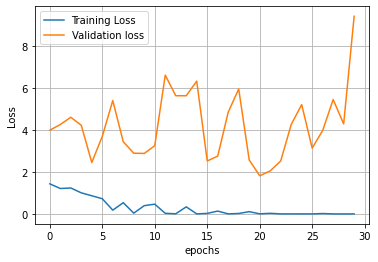

In [ ]:
plt.plot(loss, label ='Training Loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

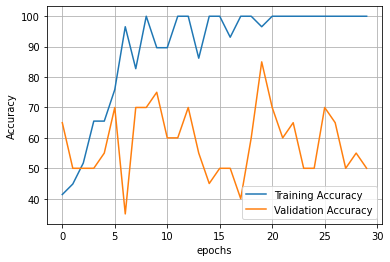

In [ ]:
plt.plot(acc, label ='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

## Testing model on new dataset

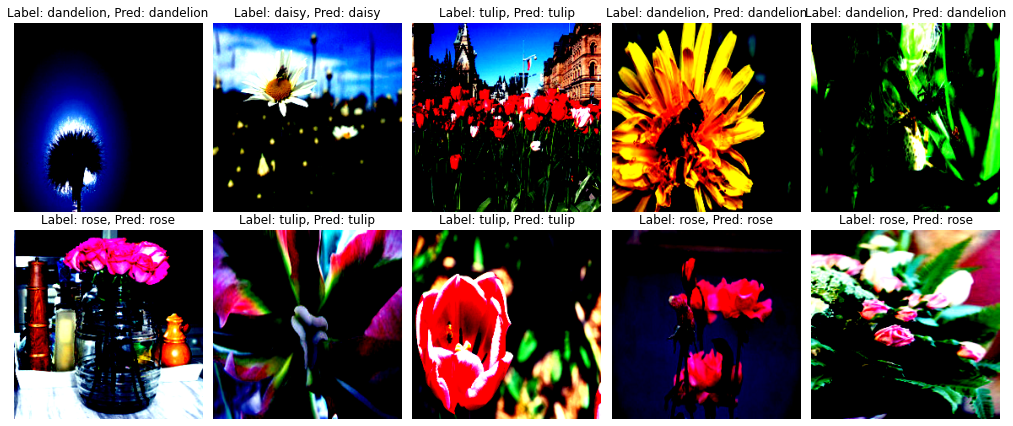

In [ ]:
def predict_flower(img, model):
  # define image
  x =img.unsqueeze(0).to(device)

  preds =model(x)
 
  _, label_idx = torch.max(preds, dim =1)
  

  #get class label
  return dataset.classes[label_idx[0]]

rows = 2
cols = 5
axes = []
fig =plt.figure(figsize=(14,6))

for i in range(rows*cols):
 
  img,label = test_set[i]
  axes.append(fig.add_subplot(rows, cols, i+1))
  sub_title = ('Label: {}, Pred: {}'.format(dataset.classes[label], predict_flower(img, model)))
  axes[-1].set_title(sub_title, fontsize=12)
  plt.imshow(img.clip(0,1).permute(1,2,0))
  plt.axis('off')
  
  #plt.title('Actual: {}, Predicted: {}'.format(dataset.classes[label], predict_flower(img, model)))

fig.tight_layout()
plt.show()

